# 使用tensorflow

tensorflow是一个强大的用于数值计算的开源软件，尤其适用于大型机器学习。
基本原则很简单：首先定义要执行的计算图， 接着tensorflow载入图，用优化过的c++代码执行。

最重要的是，可以将图形分割成多个块，并在多个cpu或gpu之间并行运行它们。也支持分布式计算，因此，你可以通过在数百台服务器上拆分计算，在合理的时间内训练庞大的神经网络。

In [28]:
# 准备工作
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

import numpy as np
import tensorflow as tf
import os

# 控制随机种子，使结果一样
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = ".."
CHAPTER_ID = "tensorflow"


def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# 创建和运行数据流图

In [133]:
import tensorflow as tf

reset_graph()
x = tf.Variable(3, name="x")
y = tf.Variable(4, name="y")
f = x * x * y + y + 2

注意， 上述代码并没有执行任何计算， 即使看起来像是执行了很多计算一样。甚至呆变量也没有初始化。要执行计算，需要创建tensorflow session， 并使用它来初始化和变量和执行计算。
Tensorflow session负责将操作放置到诸如cpu和gpu之类的设备上，并运行它们。如下执行：

In [134]:
f

<tf.Tensor 'add_1:0' shape=() dtype=int32>

In [135]:
sess = tf.Session()
sess.run(x.initializer)
sess.run(y.initializer)
result = sess.run(f)
result

42

In [136]:
sess.close()

In [137]:
with tf.Session() as sess:
    x.initializer.run()
    y.initializer.run()
    result = f.eval() #eval:串演算指令

In [138]:
result

42

In [139]:
init = tf.global_variables_initializer()
with tf.Session() as sess:
    init.run()
    result = f.eval()

In [140]:
result

42

In [141]:
init = tf.global_variables_initializer()
sess = tf.InteractiveSession()
init.run()
result = f.eval()
result

42

In [142]:
sess.close()

tensorflow程序铭心分为两部分：第一部分创建计算图，第二部分执行计算。创建过程表示创建ML模型和需要的计算过程， 执行过程通常循环计算训练的每一步，逐渐改进模型的参数。 

# 组织 数据流图

In [143]:
reset_graph()

x1 = tf.Variable(1)
x1.graph is tf.get_default_graph()

True

In [144]:
graph = tf.Graph()
with graph.as_default():
    x2 = tf.Variable(2)
x2.graph is graph

True

In [145]:
x2.graph is tf.get_default_graph()

False

In [146]:
# 节点的声明周期
w = tf.constant(3)
x = w + 2
y = x + 5
z = x * 3

with tf.Session() as sess:
    print(y.eval())  #10
    print(z.eval())  #15

10
15


In [147]:
with tf.Session() as sess:
    y_val, z_val = sess.run([y,z])
    print(y_val)
    print(z_val)

10
15



# 线性回归


tensorflow operations(ops) 可以取任意数量的输入并产生任意数量的输出。

## 使用标准方程

In [148]:

import numpy as np
from sklearn.datasets import fetch_california_housing

reset_graph()

housing = fetch_california_housing()
m, n = housing.data.shape
housing_data_plus_bias = np.c_[np.ones((m, 1)), housing.data]

X = tf.constant(housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name='y')
XT = tf.transpose(X)
theta = tf.matmul(tf.matmul(tf.matrix_inverse(tf.matmul(XT, X)), XT), y)

with tf.Session() as sess:
    theta_value = theta.eval()

In [149]:
theta_value

array([[-3.7185181e+01],
       [ 4.3633747e-01],
       [ 9.3952334e-03],
       [-1.0711310e-01],
       [ 6.4479220e-01],
       [-4.0338000e-06],
       [-3.7813708e-03],
       [-4.2348403e-01],
       [-4.3721911e-01]], dtype=float32)

## 与使用numpy计算对比

In [150]:
X = housing_data_plus_bias
y = housing.target.reshape(-1, 1)
theta_numpy = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
theta_numpy

array([[-3.69419202e+01],
       [ 4.36693293e-01],
       [ 9.43577803e-03],
       [-1.07322041e-01],
       [ 6.45065694e-01],
       [-3.97638942e-06],
       [-3.78654266e-03],
       [-4.21314378e-01],
       [-4.34513755e-01]])

## 与使用sklearn对比

In [151]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(housing_data_plus_bias, housing.target.reshape(-1, 1))

print(np.r_[lin_reg.intercept_.reshape(-1, 1), lin_reg.coef_.T])

[[-3.69419202e+01]
 [ 0.00000000e+00]
 [ 4.36693293e-01]
 [ 9.43577803e-03]
 [-1.07322041e-01]
 [ 6.45065694e-01]
 [-3.97638942e-06]
 [-3.78654265e-03]
 [-4.21314378e-01]
 [-4.34513755e-01]]


## 使用梯度下降


梯度下降首先需要进行特征缩放，可以使用tf，不过目前还是使用sklearn。

In [152]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaled_housing_data = scaler.fit_transform(housing.data)
scaled_housing_data_plus_bias = np.c_[np.ones((m, 1)), scaled_housing_data]

In [153]:
print(scaled_housing_data_plus_bais.mean(axis=0))
print(scaled_housing_data_plus_bais.mean(axis=1))
print(scaled_housing_data_plus_bais.mean())
print(scaled_housing_data_plus_bais.shape)

[ 1.00000000e+00  6.60969987e-17  5.50808322e-18  6.60969987e-17
 -1.06030602e-16 -1.10161664e-17  3.44255201e-18 -1.07958431e-15
 -8.52651283e-15]
[ 0.38915536  0.36424355  0.5116157  ... -0.06612179 -0.06360587
  0.01359031]
0.11111111111111005
(20640, 9)


### 一般方法计算梯度

In [154]:
reset_graph()

n_epochs = 1000
learning_rate = 0.01

X = tf.constant(scaled_housing_data_plus_bais, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")

y_pred = tf.matmul(X, theta, name="predications")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")
gradients = 2 / m * tf.matmul(tf.transpose(X), error)
training_op = tf.assign(theta, theta - learning_rate * gradients)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    
    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE = ", mse.eval())
        sess.run(training_op)
    
    best_theta = theta.eval()

Epoch 0 MSE =  9.161543
Epoch 100 MSE =  0.71450067
Epoch 200 MSE =  0.5667049
Epoch 300 MSE =  0.5555719
Epoch 400 MSE =  0.5488112
Epoch 500 MSE =  0.5436362
Epoch 600 MSE =  0.5396294
Epoch 700 MSE =  0.53650916
Epoch 800 MSE =  0.5340678
Epoch 900 MSE =  0.5321474


In [155]:
best_theta

array([[ 2.0685523 ],
       [ 0.8874027 ],
       [ 0.14401656],
       [-0.34770885],
       [ 0.36178368],
       [ 0.00393811],
       [-0.04269556],
       [-0.66145283],
       [-0.6375278 ]], dtype=float32)

### 使用autodiff
与上述过程一样，出了 gradients=... 这一行

注意：上述过程运行的很好，但是需要从损失函数中推导出梯度。在线性回归中，求偏导数相对容易。但是如果是执行深度神经网络，这个过程会变的困难。虽然可以计算出函数的偏导数，但是得到的代码不一定有效。  


In [156]:
reset_graph()

n_epochs = 1000
learning_rate = 0.01

X = tf.constant(scaled_housing_data_plus_bais, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")

In [157]:
gradients = tf.gradients(mse, [theta])[0]

In [158]:
training_op = tf.assign(theta, theta - learning_rate * gradients)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE =", mse.eval())
        sess.run(training_op)
    
    best_theta = theta.eval()

print("Best theta:")
print(best_theta)

Epoch 0 MSE = 9.161543
Epoch 100 MSE = 0.7145006
Epoch 200 MSE = 0.566705
Epoch 300 MSE = 0.5555719
Epoch 400 MSE = 0.5488112
Epoch 500 MSE = 0.5436362
Epoch 600 MSE = 0.5396294
Epoch 700 MSE = 0.5365092
Epoch 800 MSE = 0.5340678
Epoch 900 MSE = 0.5321474
Best theta:
[[ 2.0685525 ]
 [ 0.8874027 ]
 [ 0.14401658]
 [-0.34770882]
 [ 0.36178368]
 [ 0.00393811]
 [-0.04269556]
 [-0.6614528 ]
 [-0.6375277 ]]


##### 如何求出如下关于a，b函数的偏导数？

In [159]:
def my_func(a, b):
    z = 0
    for i in range(100):
        z = a * np.cos(z + i) + z * np.sin(b - i)
    return z

In [160]:
my_func(0.2, 0.3)

-0.21253923284754916

## autodiff
tensorflow 的autodiff 特征可以自动并且有效的计算梯度，如下代码所示：
gradients() 函数的将 一个op 和一个变量列表，根据每个变量执行一组列表ops操作， 计算op的梯度。 因此下面代码，gradients 将根据 $\theta$ 和mse 操作 计算梯度向量。

In [161]:
reset_graph()

a = tf.Variable(0.2, name="a")
b = tf.Variable(0.3, name="b")
z = tf.Variable(0.0, name="z0")

for i in range(100):
    z = a * tf.cos(z + i) + z * tf.sin(b - i)

grads = tf.gradients(z, [a, b])
init = tf.global_variables_initializer()

###### 下面计算函数在$a=0.2$ 和 $b=0.3$， 并且关于a, b点的偏导数：

In [162]:
with tf.Session() as sess:
    init.run()
    print(z.eval())
    print(sess.run(grads))

-0.21253741
[-1.1388494, 0.19671395]


## 使用梯度下降优化

In [163]:
reset_graph()

n_epochs = 1000
learing_rate = 0.01


X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")

In [164]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate)
training_op = optimizer.minimize(mse)

In [165]:
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE =", mse.eval())
        sess.run(training_op)
    
    best_theta = theta.eval()

print("Best theta:")
print(best_theta)

Epoch 0 MSE = 9.161543
Epoch 100 MSE = 0.7145006
Epoch 200 MSE = 0.566705
Epoch 300 MSE = 0.5555719
Epoch 400 MSE = 0.5488112
Epoch 500 MSE = 0.5436362
Epoch 600 MSE = 0.5396294
Epoch 700 MSE = 0.5365092
Epoch 800 MSE = 0.5340678
Epoch 900 MSE = 0.5321474
Best theta:
[[ 2.0685525 ]
 [ 0.8874027 ]
 [ 0.14401658]
 [-0.34770882]
 [ 0.36178368]
 [ 0.00393811]
 [-0.04269556]
 [-0.6614528 ]
 [-0.6375277 ]]


#### 使用 动量优化

In [166]:
reset_graph()

n_epochs = 1000
learning_rate = 0.01

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")

In [167]:
optimizer = tf.train.MomentumOptimizer(learning_rate = learning_rate, momentum=0.9)

In [168]:
training_op = optimizer.minimize(mse)
init = tf.global_variables_initializer()

In [169]:
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(n_epochs):
        sess.run(training_op)
    best_theta = theta.eval()
    
print("Best theta:")
print(best_theta)

Best theta:
[[ 2.068558  ]
 [ 0.8296286 ]
 [ 0.11875337]
 [-0.26554456]
 [ 0.3057109 ]
 [-0.00450251]
 [-0.03932662]
 [-0.89986444]
 [-0.87052065]]


# 将数据输入到训练算法

## 占位节点 (Placeholder nodes)
该节点不执行任何运算，只是输出你告诉他们在运行时输出的数据。
在训练过程中，它们通常被用来将训练数据传递给TensorFlow。如果在运行时没有为占位符指定值，则会得到一个异常。

In [170]:
reset_graph()
A = tf.placeholder(tf.float32, shape=(None, 3))
B = A + 5
with tf.Session() as sess:
    B_val_1 = B.eval(feed_dict={A:[[1,2,3]]})
    B_val_2 = B.eval(feed_dict={A:[[4, 5, 6], [7, 8, 9]]})
print(B_val_1)
print(B_val_2)

[[6. 7. 8.]]
[[ 9. 10. 11.]
 [12. 13. 14.]]


## 小批量梯度下降

In [171]:
n_epochs = 1000
learning_rate = 0.01

In [172]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n + 1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")

In [173]:
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42),name="theta")
y_pred = tf.matmul(X, theta, name="predictions")

error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name='mse')

optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()

In [174]:
n_epochs = 10
batch_size = 100
n_batches = int(np.ceil(m / batch_size))
n_batches

207

In [175]:
def fetch_batch(epochs, batch_index, batch_size):
    np.random.seed(epochs * n_batches + batch_index)
    indices = np.random.randint(m, size=batch_size)
    X_batch = scaled_housing_data_plus_bias[indices]
    y_batch = housing.target.reshape(-1, 1)[indices]
    return X_batch, y_batch

with tf.Session() as sess:
    sess.run(init)
    
    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = fetch_batch(epoch, batch_index, batch_size)
            sess.run(training_op, feed_dict={X:X_batch, y:y_batch})
    best_theta = theta.eval()

In [176]:
best_theta

array([[ 2.0703337 ],
       [ 0.8637145 ],
       [ 0.12255151],
       [-0.31211874],
       [ 0.38510373],
       [ 0.00434168],
       [-0.01232954],
       [-0.83376896],
       [-0.8030471 ]], dtype=float32)

# 保存和加载模型
模型训练完之后，需要保存参数，以便后续使用， 或者和其他模型比较。
或者在运行过程中有规律的保存模型，防止程序崩溃后，又重新开始。

使用tensorflow的saver可以方便的保存和加载。

In [177]:
reset_graph()

n_epochs = 1000                                                                       # not shown in the book
learning_rate = 0.01                                                                  # not shown

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")            # not shown
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")            # not shown
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")                                      # not shown
error = y_pred - y                                                                    # not shown
mse = tf.reduce_mean(tf.square(error), name="mse")                                    # not shown
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)            # not shown
training_op = optimizer.minimize(mse)                                                 # not shown

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE =", mse.eval())                                # not shown
            save_path = saver.save(sess, "../tmp/my_model.ckpt")
        sess.run(training_op)
    
    best_theta = theta.eval()
    save_path = saver.save(sess, "../tmp/my_model_final.ckpt")

Epoch 0 MSE = 9.161543
Epoch 100 MSE = 0.7145006
Epoch 200 MSE = 0.566705
Epoch 300 MSE = 0.5555719
Epoch 400 MSE = 0.5488112
Epoch 500 MSE = 0.5436362
Epoch 600 MSE = 0.5396294
Epoch 700 MSE = 0.5365092
Epoch 800 MSE = 0.5340678
Epoch 900 MSE = 0.5321474


In [178]:
best_theta

array([[ 2.0685525 ],
       [ 0.8874027 ],
       [ 0.14401658],
       [-0.34770882],
       [ 0.36178368],
       [ 0.00393811],
       [-0.04269556],
       [-0.6614528 ],
       [-0.6375277 ]], dtype=float32)

In [179]:
with tf.Session() as sess:
    saver.restore(sess, "../tmp/my_model_final.ckpt")
    best_theta_restored = theta.eval() # not shown in the book

INFO:tensorflow:Restoring parameters from ../tmp/my_model_final.ckpt


In [180]:
np.allclose(best_theta, best_theta_restored)

True

In [181]:
# 如果想换一个名字保存， 可以使用如下方法：
saver = tf.train.Saver({"weights": theta})

默认的，saver还将计算图本身保存在扩展名为.meta的第二个文件中。 可以使用函数`tf.train.import_mate_graph()`重载计算图。
这个函数将图形加载到默认图中，并返回一个可用于恢复图状态的Saver。

In [182]:
reset_graph()
# 开始为空
saver = tf.train.import_meta_graph("../tmp/my_model_final.ckpt.meta")
theta = tf.get_default_graph().get_tensor_by_name("theta:0")

with tf.Session() as sess:
    saver.restore(sess, "../tmp/my_model_final.ckpt")
    best_theta_restore = theta.eval()
    

INFO:tensorflow:Restoring parameters from ../tmp/my_model_final.ckpt


In [183]:
np.allclose(best_theta, best_theta_restored)

True

这意味着 可以导入之间训练过得模型， 而不必用相应的python代码来构建计算图。
当您不断调整并保存您的模型时，这非常有用:您可以加载以前保存的模型，而不必搜索构建它的代码的版本。

# 可视化计算图


In [184]:
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = b"<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '"'))
    display(HTML(iframe))

## 使用tensorBoard

In [185]:
reset_graph()
from datetime import datetime

now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "../tf_logs"
logdir = "{}/run-{}/".format(root_logdir, now)

In [186]:

n_epochs = 1000
learning_rate = 0.01

X = tf.placeholder(tf.float32, shape=(None, n + 1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()

In [187]:
mse_summary = tf.summary.scalar("MSE", mse)
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

In [188]:
n_epochs = 10
batch_size = 100
n_batches = int(np.ceil(m / batch_size))

In [189]:
with tf.Session() as sess:                                                        # not shown in the book
    sess.run(init)                                                                # not shown

    for epoch in range(n_epochs):                                                 # not shown
        for batch_index in range(n_batches):
            X_batch, y_batch = fetch_batch(epoch, batch_index, batch_size)
            if batch_index % 10 == 0:
                summary_str = mse_summary.eval(feed_dict={X: X_batch, y: y_batch})
                step = epoch * n_batches + batch_index
                file_writer.add_summary(summary_str, step)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})

    best_theta = theta.eval()                                                     # not shown

In [190]:
file_writer.close()

In [191]:
best_theta

array([[ 2.0703337 ],
       [ 0.8637145 ],
       [ 0.12255151],
       [-0.31211874],
       [ 0.38510373],
       [ 0.00434168],
       [-0.01232954],
       [-0.83376896],
       [-0.8030471 ]], dtype=float32)

有了上述保存的文件， 执行如下命令可以进行可视化：
```
    $ tensorboard --logdir tf_logs/
    Starting TensorBoard  on port 6006
    (You can navigate to http://0.0.0.0:6006)
```

# 变量作用域
当处理很复杂的模型(神经网络)时，这个图形很容易被成千上万个节点所包围。为了避免这种情况，您可以为相关的节点创建作用域。 如下代码：


In [192]:
reset_graph()

now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "../tf_logs"
logdir = "{}/run-{}/".format(root_logdir, now)

n_epochs = 1000
learning_rate = 0.01


X = tf.placeholder(tf.float32, shape=(None, n + 1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")

In [193]:
with tf.name_scope("loss") as scope:
    error = y_pred - y
    mse = tf.reduce_mean(tf.square(error), name="mse")

In [194]:

optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()

mse_summary = tf.summary.scalar('MSE', mse)
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

In [195]:
n_epochs = 10
batch_size = 100
n_batches = int(np.ceil(m / batch_size))

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = fetch_batch(epoch, batch_index, batch_size)
            if batch_index % 10 == 0:
                summary_str = mse_summary.eval(feed_dict={X: X_batch, y: y_batch})
                step = epoch * n_batches + batch_index
                file_writer.add_summary(summary_str, step)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})

    best_theta = theta.eval()

file_writer.flush()
file_writer.close()
print("Best theta:")
print(best_theta)

Best theta:
[[ 2.0703337 ]
 [ 0.8637145 ]
 [ 0.12255151]
 [-0.31211874]
 [ 0.38510373]
 [ 0.00434168]
 [-0.01232954]
 [-0.83376896]
 [-0.8030471 ]]


In [196]:
print(error.op.name)

loss/sub


In [197]:
print(mse.op.name)

loss/mse


In [199]:
reset_graph()
a1 = tf.Variable(0,name="a")
a2 = tf.Variable(0,name="a")

with tf.name_scope("param"):
    a3 = tf.Variable(0, name="a")

with tf.name_scope("param"):       # name == "param_1"
    a4 = tf.Variable(0, name="a")  # name == "param_1/a"

for node in (a1, a2, a3, a4):
    print(node.op.name)

a
a_1
param/a
param_1/a


# 模块化

In [200]:
# 下面代码结构比较差：
n_features = 3

X = tf.placeholder(tf.float32, shape=(None, n_features), name="X")

w1 = tf.Variable(tf.random_normal((n_features, 1)), name="weights1")
w2 = tf.Variable(tf.random_normal((n_features, 1)), name="weights2")
b1 = tf.Variable(0.0, name="bias1")
b2 = tf.Variable(0.0, name="bias2")

z1 = tf.add(tf.matmul(X, w1), b1, name="z1")
z2 = tf.add(tf.matmul(X, w2), b2, name="z2")

relu1 = tf.maximum(z1, 0., name="relu1")
relu2 = tf.maximum(z1, 0., name="relu2")  # Oops, cut&paste error! Did you spot it?

output = tf.add(relu1, relu2, name="output")

In [201]:
# 进行一些改进
def relu(X):
    w_shape = (int(X.get_shape()[1]), 1)
    w = tf.Variable(tf.random_normal(w_shape), name="weights")
    b = tf.Variable(0.0, name="bias")
    z = tf.add(tf.matmul(X, w), b, name="z")
    return tf.maximum(z, 0., name="relu")

n_features = 3
X = tf.placeholder(tf.float32, shape=(None, n_features), name="X")
relus = [relu(X) for i in range(5)]
output = tf.add_n(relus, name="output")

In [202]:
file_writer = tf.summary.FileWriter("logs/relu1", tf.get_default_graph())

In [203]:
# 更好的是使用scopes：
reset_graph()

def relu(X):
    with tf.name_scope("relu"):
        w_shape = (int(X.get_shape()[1]), 1)                          # not shown in the book
        w = tf.Variable(tf.random_normal(w_shape), name="weights")    # not shown
        b = tf.Variable(0.0, name="bias")                             # not shown
        z = tf.add(tf.matmul(X, w), b, name="z")                      # not shown
        return tf.maximum(z, 0., name="max")

In [204]:
n_features = 3
X = tf.placeholder(tf.float32, shape=(None, n_features), name="X")
relus = [relu(X) for i in range(5)]
output = tf.add_n(relus, name="output")

file_writer = tf.summary.FileWriter("logs/relu2", tf.get_default_graph())
file_writer.close()

# 共享变量
当不同代码需要使用同一个变量时，可以当做参数，或者新建字典，新建类来访问。

In [205]:
reset_graph()

def relu(X, threshold):
    with tf.name_scope("relu"):
        w_shape = (int(X.get_shape()[1]), 1)                        # not shown in the book
        w = tf.Variable(tf.random_normal(w_shape), name="weights")  # not shown
        b = tf.Variable(0.0, name="bias")                           # not shown
        z = tf.add(tf.matmul(X, w), b, name="z")                    # not shown
        return tf.maximum(z, threshold, name="max")

threshold = tf.Variable(0.0, name="threshold")
X = tf.placeholder(tf.float32, shape=(None, n_features), name="X")
relus = [relu(X, threshold) for i in range(5)]
output = tf.add_n(relus, name="output")


In [206]:
reset_graph()

def relu(X):
    with tf.name_scope("relu"):
        if not hasattr(relu, "threshold"):
            relu.threshold = tf.Variable(0.0, name="threshold")
        w_shape = int(X.get_shape()[1]), 1                          # not shown in the book
        w = tf.Variable(tf.random_normal(w_shape), name="weights")  # not shown
        b = tf.Variable(0.0, name="bias")                           # not shown
        z = tf.add(tf.matmul(X, w), b, name="z")                    # not shown
        return tf.maximum(z, relu.threshold, name="max")

In [207]:

X = tf.placeholder(tf.float32, shape=(None, n_features), name="X")
relus = [relu(X) for i in range(5)]
output = tf.add_n(relus, name="output")

tf提供了另一种方法， 使用 get_variable() 函数，创建共享变量(不存在创建，存在重用)。其行为由variable_scope() 函数来控制。
比如下面代码 新建一个变量 "resu/threshold"。 

但是这种情况下，如果变量之前已经存在， 会报异常， 因此用于防止变量错误重用。  

第二段代码则添加reuse属性，不用指定shape和初始化，可以重用变量。 将会寻找已经存在的变量，不存在则报异常。  

第三段代码则将resue放在代码块里面。

In [209]:
reset_graph()

with tf.variable_scope("relu"):
    threshold = tf.get_variable("threshold", shape=(),
                                initializer=tf.constant_initializer(0.0))
    
with tf.variable_scope("relu", reuse=True):
    threshold = tf.get_variable("threshold")
    
with tf.variable_scope("relu") as scope:
    scope.reuse_variables()
    threshold = tf.get_variable("threshold")

In [210]:
reset_graph()

def relu(X):
    with tf.variable_scope("relu", reuse=True):
        threshold = tf.get_variable("threshold")
        w_shape = int(X.get_shape()[1]), 1                          # not shown
        w = tf.Variable(tf.random_normal(w_shape), name="weights")  # not shown
        b = tf.Variable(0.0, name="bias")                           # not shown
        z = tf.add(tf.matmul(X, w), b, name="z")                    # not shown
        return tf.maximum(z, threshold, name="max")

X = tf.placeholder(tf.float32, shape=(None, n_features), name="X")
with tf.variable_scope("relu"):
    threshold = tf.get_variable("threshold", shape=(),
                                initializer=tf.constant_initializer(0.0))
relus = [relu(X) for relu_index in range(5)]
output = tf.add_n(relus, name="output")

In [211]:
file_writer = tf.summary.FileWriter("logs/relu6", tf.get_default_graph())
file_writer.close()

In [212]:
reset_graph()

def relu(X):
    with tf.variable_scope("relu"):
        threshold = tf.get_variable("threshold", shape=(), initializer=tf.constant_initializer(0.0))
        w_shape = (int(X.get_shape()[1]), 1)
        w = tf.Variable(tf.random_normal(w_shape), name="weights")
        b = tf.Variable(0.0, name="bias")
        z = tf.add(tf.matmul(X, w), b, name="z")
        return tf.maximum(z, threshold, name="max")

X = tf.placeholder(tf.float32, shape=(None, n_features), name="X")
with tf.variable_scope("", default_name="") as scope:
    first_relu = relu(X)     # create the shared variable
    scope.reuse_variables()  # then reuse it
    relus = [first_relu] + [relu(X) for i in range(4)]
output = tf.add_n(relus, name="output")

file_writer = tf.summary.FileWriter("logs/relu8", tf.get_default_graph())
file_writer.close()

In [213]:
reset_graph()

def relu(X):
    threshold = tf.get_variable("threshold", shape=(),
                                initializer=tf.constant_initializer(0.0))
    w_shape = (int(X.get_shape()[1]), 1)                        # not shown in the book
    w = tf.Variable(tf.random_normal(w_shape), name="weights")  # not shown
    b = tf.Variable(0.0, name="bias")                           # not shown
    z = tf.add(tf.matmul(X, w), b, name="z")                    # not shown
    return tf.maximum(z, threshold, name="max")

X = tf.placeholder(tf.float32, shape=(None, n_features), name="X")
relus = []
for relu_index in range(5):
    with tf.variable_scope("relu", reuse=(relu_index >= 1)) as scope:
        relus.append(relu(X))
output = tf.add_n(relus, name="output")

In [214]:
file_writer = tf.summary.FileWriter("logs/relu9", tf.get_default_graph())
file_writer.close()

# 补充资料

In [218]:
reset_graph()

with tf.variable_scope("my_scope"):
    x0 = tf.get_variable("x", shape=(), initializer=tf.constant_initializer(0.))
    x1 = tf.Variable(0., name="x")
    x2 = tf.Variable(0., name="x")

with tf.variable_scope("my_scope", reuse=True):
    x3 = tf.get_variable("x")
    x4 = tf.Variable(0., name="x")
    
with tf.variable_scope("", default_name="", reuse=True):
    x5 = tf.get_variable("my_scope/x")

In [219]:
print("x0:", x0.op.name)
print("x1:", x1.op.name)
print("x2:", x2.op.name)
print("x3:", x3.op.name)
print("x4:", x4.op.name)
print("x5:", x5.op.name)
print(x0 is x3 and x3 is x5)

x0: my_scope/x
x1: my_scope/x_1
x2: my_scope/x_2
x3: my_scope/x
x4: my_scope_1/x
x5: my_scope/x
True


### 字符串

In [220]:
reset_graph()

text = np.array("Do you want some café?".split())
text_tensor = tf.constant(text)

with tf.Session() as sess:
    print(text_tensor.eval())

[b'Do' b'you' b'want' b'some' b'caf\xc3\xa9?']


# 课后习题

##### 1.创建计算图相比直接计算的优点是什么?主要的缺点是什么？
优点：
tensorflow可以使用reverse-mode autodiff自动计算梯度。
TensorFlow可以处理在不同线程中并行运行的操作
在不同设备运行相同的模型
可以在TensorBoard中查看模型

缺点：
学习曲线更加陡峭，调试更加困难。


##### 2. a_val = a.eval(session=sess) 与 a_val = sess.run(a) 的结果相等吗？ 
相等

##### 3. a_val, b_val = a.eval(session=sess), b.eval(ses sion=sess)和 a_val, b_val = sess.run([a, b]) 的计算结果相等吗？
不相等。   
前者两次执行计算图， 后者只执行一次。  
如果任何op有副作用， 其结果也会不同。如果没有副作用，两个返回结果相同，但是后者运行速度好于前者。

##### 4. 在同一个session 中可以执行两个计算图吗？
不行，不能在同一个session中执行两个计算图。必须合并到一个计算图中。

##### 5. 如果创建包含变脸w的计算图g，启动两个线程并每个线程打开一个session，都同时用到g， 每个session拥有各自独立的w还是共享w？
在本地tensorfolw中，session管理变量。如题目所示，每个session有拥有w的副本。然而在分布式tensorflow中，变由cluster保存并管理，如果两个session都使用用一个容器， 连接到同一个cluster，则共享变量w。 

##### 6. 变量什么时候初始化？什么时候销毁？
当调用initializer时初始化，当sessions结束时销毁。在分布式tensorflow中，变量保存在cluster的容器中， session关闭并不会销毁变量， 而是清理container时销毁。

##### 7. placeholder和variable之前的区别是什么？
有极大的不同:
variable是持有值的操作。如果运行variable， 返回值。在运行之前， 需要初始化。可以修改其值（比如使用 assignment 操作）。它是有状态的：变量在图的连续运行中保持相同的值。
它是一种类型，用于保存模型参数，但也用于其他目的(例如，计算全局训练步骤)。

而Placeholders: 只是持有type和shape的tensor的信息，没有确切的值。实际上， 如果计算一个依赖placeholder的操作，必须提供相应的值(feed_dict),否则会得到一个异常。

##### 8. 当去计算一个op， 其placeholder还没有feed数据的时候会发生什么？如果该op不依赖placeholder又会发生什么？
会得到一个异常。  如果不依赖placeholder， 没有异常。

##### 9. 当运行计算图时， 能提供任何操作的输出值，还是只是占位符的值吗？
当您运行一个图表时，您可以提供任何操作的输出值，而不仅仅是占位符的值。然而，在实践中，这是相当罕见的(例如，当您在缓存冻结层的输出时，它可能是有用的)

##### 10. 如何将变量设置为您想要的任何值(在执行阶段)?
当创建计算图时可以指定变量的初始值，之后在执行语句，运行初始化时变量将会被初始化。如果在后面的运行过程中先改变变量的值，最简单的操作是使用赋值语句（在创建图语句中） tf.assign()语句， 传入变量和placeholder。在执行阶段，可以运行赋值操作，提供新的变量值。

##### 11. 当计算包含10个变量的损失函数的梯度时，reverse-mode autodiff 需要遍历多少次计算图？如果是forward-mode autodiff呢？区别是什么？
reverse-mode autodiff 需要遍历两次计算图，以便计算损失函数的梯度。另一方面， forward-mode autodiff 需要根据变量数，每个变量遍历一次。  
明显的区别在于，后者会创建一个不同的计算图去计算梯度，而不是遍历原计算图。
一个高度优化的系统可能只需要一次运行新的梯度图来计算所有变量的梯度，但是新的图形可能会非常复杂和低效，与原始图相比。

##### 12. 用小批量梯度下降实现逻辑回归。在moons 数据集上训练并计算。 
1. 定义计算图， logistics_regerssion(), 实现函数重用。
2. 在训练过程中，定期使用Saver保存检查点，并在训练结束时保存最终的模型。
3. 如果程序中断，  重载最后保存的模型。
4. 使用漂亮的范围来定义图表，这样图表看起来很好。
5. 添加summaries ， 便于可视化。
6. 试着调整一些超参数，比如学习速率或者小批量大小，看看学习曲线的形状。

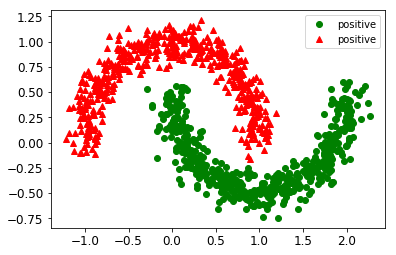

In [9]:
from sklearn.datasets import make_moons
m = 1000
X_moons, y_moons = make_moons(m, noise=0.1, random_state=42)

# 可视化
plt.plot(X_moons[y_moons==1, 0], X_moons[y_moons==1, 1], "go", label="positive")
plt.plot(X_moons[y_moons==0, 0], X_moons[y_moons==0, 1], "r^", label="positive")
plt.legend()
plt.show()

In [11]:
#不能忘记忘记对每个实例添加偏置项（$x_0 = 1$）。需要在矩阵的左边遍历一列。
X_moons_with_bias = np.c_[np.ones([m, 1]), X_moons]

In [13]:
#简单检查
X_moons_with_bias[:5]

array([[ 1.        , -0.05146968,  0.44419863],
       [ 1.        ,  1.03201691, -0.41974116],
       [ 1.        ,  0.86789186, -0.25482711],
       [ 1.        ,  0.288851  , -0.44866862],
       [ 1.        , -0.83343911,  0.53505665]])

In [15]:
#现在变换y_train为列向量，（每行是2D 数组）。
y_moons_column_vector = y_moons.reshape(-1, 1)

In [16]:
# 切分数据为训练集和测试集
test_radio = 0.2
test_size = int(m * 0.2)
X_train = X_moons_with_bias[:-test_size]
y_train = y_moons_column_vector[:-test_size]

X_test = X_moons_with_bias[-test_size:]
y_test = X_moons_with_bias[-test_size:]

下面创建一个生成训练集的函数。随机选取每个批量的训练实例。意味着单独的patch可能会多次包括相同的实例， 并且可能不会全覆盖到所有的实例。然而，实际上问题不大。

In [21]:
def random_batch(X_train, y_train, batch_size):
    rnd_indices = np.random.randint(0, len(X_train), batch_size)
    X_batch = X_train[rnd_indices]
    y_batch = y_train[rnd_indices]
    return X_batch, y_batch

In [25]:
# 看一下随机的结果
X_batch, y_batch = random_batch(X_train, y_train, 5)
X_batch  

array([[ 1.        ,  1.81702614, -0.41205437],
       [ 1.        , -0.14780171,  0.16037205],
       [ 1.        ,  1.07172763,  0.13482039],
       [ 1.        , -0.83986573,  0.31168093],
       [ 1.        , -0.72480745,  1.05480753]])

In [26]:
y_batch

array([[1],
       [1],
       [0],
       [0],
       [0]])

###### 准备工作已经做好，准备创建模型，提供数据。

In [83]:
reset_graph()

In [84]:
# 输入数据有两个特征，是2维的。
n_inputs = 2

创建逻辑回归模型。

In [85]:
X = tf.placeholder(tf.float32, shape=(None, n_inputs + 1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")
theta = tf.Variable(tf.random_uniform([n_inputs + 1, 1], -1.0, 1.0, seed=42), name="theta")
logits = tf.matmul(X, theta, name="logits")
y_proba = 1 / (1 + tf.exp(-logits))

In [86]:
#实际上，tf提供了sigmod函数：
y_proba = tf.sigmoid(logits)

$J(\mathbf{\theta}) = -\dfrac{1}{m} \sum\limits_{i=1}^{m}{\left[ y^{(i)} log\left(\hat{p}^{(i)}\right) + (1 - y^{(i)}) log\left(1 - \hat{p}^{(i)}\right)\right]}$


In [87]:
epsilon = 1e-7 # 防止计算时溢出
loss = -tf.reduce_mean(y * tf.log(y_proba + epsilon) + (1 - y) * (tf.log(1 - y_proba + epsilon)))

In [88]:
# 同时也可以使用tf的内置函数：
loss = tf.losses.log_loss(y, y_proba)  # uses epsilon = 1e-7 by default

余下的部分：创建优化器并且优化损失函数


In [89]:
learning_rate = 0.01
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate)
training_op = optimizer.minimize(loss)

In [90]:
# 执行初始化语句
init = tf.global_variables_initializer()

接下来开始训练模型并进行预测。 
代码与之前线性回归的类似。

In [91]:
n_epochs = 1000
batch_size = 50
n_batches = int(np.ceil(m / batch_size))

In [92]:
n_epochs = 1000
batch_size = 50
n_batches = int(np.ceil(m / batch_size))

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = random_batch(X_train, y_train, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val = loss.eval({X: X_test, y: y_test})
        if epoch % 100 == 0:
            print("Epoch:", epoch, "\tLoss:", loss_val)

    y_proba_val = y_proba.eval(feed_dict={X: X_test, y: y_test})

ValueError: Cannot feed value of shape (200, 3) for Tensor 'y:0', which has shape '(?, 1)'